# Modeling

## Open items to do 
 - utilize cross validation to measure model performance
 - utilize cross validation to make predictions on training data not the test data
 - **set classes to be predicted with a measure of Biden's victory that takes MOE into consideration**
 - include measures such as precison and recall to really gauge performance of models
 - most important 
 - **ROC curves**
 - **XGBOOST model**
 - can this be done with a deep learning model
 - Readme
 - start making dashboards/outputs
 - **get new data and add to see if scores are any better**
 - **feature importance - take out the feature that might be to close to the target**
 - see if GridSearch has CrossValidation
 - **clean up the EDA notebook**
 - SQL

In [1]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [2]:
import seaborn as sns
import pandas as pd
import datetime as dt
import eli5

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be 

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer 
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.regressor import PredictionError
from yellowbrick.classifier import ConfusionMatrix

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# getting tweet df up and running
Master_tweet_df = pd.read_csv('data/Master_Tweet_modelready.csv')

## Variable Designation

In [5]:
X_values = Master_tweet_df.drop('Target',axis=1)

In [6]:
X = X_values
y= Master_tweet_df.iloc[:,-1]

## Data Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.15)

In [8]:
def datetime_to_int(dt):
    return int(dt.strftime("%Y%m%d"))

In [9]:
X_train['date'] = X_train['date'].astype(int)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Pipeline Creation

In [10]:
clf = Pipeline(steps = [('scaler',StandardScaler()),('dummy',DummyRegressor())])

In [11]:
#Classifer being used in current Pipeline so future changes can be made
Model = DummyRegressor()

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count', 'replies_count','retweets_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

#categorical_features = ['Target']
#categorical_transformer = Pipeline([('imputer',SimpleImputer(strategy='constant',fill_value='Likely Trump'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
        #('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])

## Models

### Baseline Model

In [12]:
clf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['likes_count',
                                                   'replies_count',
                                                   'retweets_count',
                                                   'word_count',
                                                   'avg_word_length',
                                                   'stopwords_count',
                                                   'char_count',
                                                   'Sentiment'])])),
                ('classifier', DummyRegressor())])

In [13]:
clf.score(X_test,y_test)

-0.0004730752308785835

### Decision Tree Classifier

I tried a regression analysis because scores on the classifier were coming out to high. I will switch this back to a classifier.

In [14]:
#Classifer being used in current Pipeline so future changes can be made
Model = DecisionTreeClassifier()

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count', 'replies_count','retweets_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

#categorical_features = ['Target']
#categorical_transformer = Pipeline([('imputer',SimpleImputer(strategy='constant',fill_value='Likely Trump'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
        #('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])

In [15]:
## Finding best parameters
parameters={'criterion': ('gini','entropy'), 'splitter': ('best', 'random')}

model = DecisionTreeClassifier()

clf_DT = GridSearchCV(model, parameters)
clf_DT.fit(X_train,y_train)


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'splitter': ('best', 'random')})

In [16]:
#Results of GridSearchCV
print('\n ============================================================================================')
print('\n Results of the GridSearchCV on Decision Tree Classifier')
print('\n ============================================================================================')
print('\n The best parameters to use in a model are: \n',clf_DT.best_params_)
print('\n The best score achieved is: \n',clf_DT.best_score_ )
print('\n ============================================================================================')



 Results of the GridSearchCV on Decision Tree Classifier


 The best parameters to use in a model are: 
 {'criterion': 'gini', 'splitter': 'random'}

 The best score achieved is: 
 0.9991707934495832



In [17]:
#fitting and making predictions with model
clf_DT = DecisionTreeClassifier(criterion='entropy',splitter='random')
clf_DT.fit(X_train,y_train)
clf_DT.predict(X_test)

array([ 8., 10., 10., ...,  6.,  4.,  6.])

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


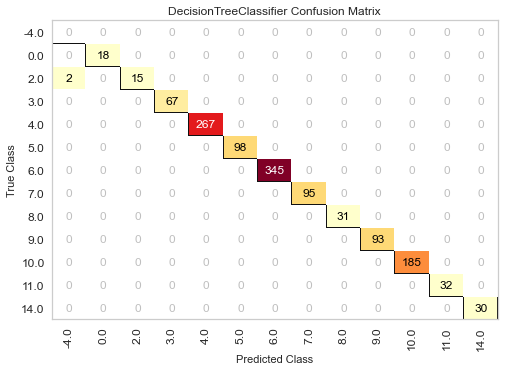

<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [18]:
#Confusion Matrix
model = DecisionTreeClassifier()
visualizer = ConfusionMatrix(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [19]:
#Finding the feature importance
eli5.explain_weights(clf_DT)

Weight,Feature
0.2770,x0
0.2756,x1
0.2537,x6
0.1930,x7
0.0006,x10
0.0002,x11
0,x12
0,x9
0,x8
0,x5


Based on the feature importance chart, the death feature informs the target variable the most. We will take it out of our model to see how it makes the results more practical.

### Decision Tree with Deaths Removed

In [20]:
X_values_feature = X_values.drop('date',axis=1)

In [21]:
X_values_feature

,Unnamed: 0,likes_count,replies_count,retweets_count,video,Cases_x,Deaths_x,word_count,avg_word_length,stopwords_count,char_count,Sentiment
0,0,4374,464,2189,0,12,0,41,5.536585,16,269,0.000000
1,1,0,0,0,0,13,0,38,7.894737,15,338,0.375000
2,2,0,0,0,0,13,0,37,8.500000,15,361,0.375000
3,3,0,0,0,0,13,0,39,8.550000,15,382,0.048611
4,4,0,0,0,0,13,0,34,8.457143,10,330,0.216667
...,...,...,...,...,...,...,...,...,...,...,...,...
8509,8509,0,0,0,0,2000702,113631,51,3.882353,21,248,0.433333
8510,8510,0,1,0,0,2000702,113631,55,4.129630,22,277,-0.354762
8511,8511,0,0,0,0,2000702,113631,50,3.979167,17,240,-0.266667
8512,8512,159,28,40,0,2000702,113631,36,5.722222,13,242,0.250000


In [22]:
#Splitting the data
Feature_X_train, Feature_X_test, y_train, y_test = train_test_split(X_values_feature, y,test_size=.15)

In [23]:
#Classifer being used in current Pipeline so future changes can be made
Model = DecisionTreeClassifier()

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count', 'replies_count','retweets_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

#categorical_features = ['Target']
#categorical_transformer = Pipeline([('imputer',SimpleImputer(strategy='constant',fill_value='Likely Trump'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
        #('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])

In [24]:
## Finding best parameters
parameters={'criterion': ('gini','entropy'), 'splitter': ('best', 'random')}

model = DecisionTreeClassifier()

clf_DT = GridSearchCV(model, parameters)
clf_DT.fit(Feature_X_train,y_train)


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'splitter': ('best', 'random')})

In [25]:
#Results of GridSearchCV
print('\n ============================================================================================')
print('\n Results of the GridSearchCV on Decision Tree Classifier - without Death')
print('\n ============================================================================================')
print('\n The best parameters to use in a model are: \n',clf_DT.best_params_)
print('\n The best score achieved is: \n',clf_DT.best_score_ )
print('\n ============================================================================================')



 Results of the GridSearchCV on Decision Tree Classifier - without Death


 The best parameters to use in a model are: 
 {'criterion': 'gini', 'splitter': 'random'}

 The best score achieved is: 
 0.9994472274509654



### Random Forest Classifier

In [26]:
## Finding best parameters
parameters={'n_estimators': (100,500,1100), 'criterion': ('gini', 'entropy'),
           'max_features': ('auto', 'sqrt', 'log2','int','float'),}

model = RandomForestClassifier()

clf_RFC = GridSearchCV(model, parameters)

In [27]:
clf_RFC.fit(X_train,y_train)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/op

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _disp

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_features': ('auto', 'sqrt', 'log2', 'int',
                                          'float'),
                         'n_estimators': (100, 500, 1100)})

In [28]:
#Results of GridSearchCV
print('\n ============================================================================================')
print('\n Results of the GridSearchCV on Random Forest Classifier')
print('\n ============================================================================================')
print('\n The best parameters to use in a model are: \n',clf_RFC.best_params_)
print('\n The best score achieved is: \n',clf_RFC.best_score_ )



 Results of the GridSearchCV on Random Forest Classifier


 The best parameters to use in a model are: 
 {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1100}

 The best score achieved is: 
 0.22664524048612672


In [29]:
#Classifer being used in current Pipeline so future changes can be made
Model = RandomForestClassifier(criterion='gini',max_features='auto',n_estimators=100)

#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count', 'replies_count','retweets_count','word_count','avg_word_length','stopwords_count',
                   'char_count','Sentiment']
numeric_transformer = Pipeline([('scaler',StandardScaler())])

#categorical_features = ['Target']
#categorical_transformer = Pipeline([('imputer',SimpleImputer(strategy='constant',fill_value='Likely Trump'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
        #('cat', categorical_transformer, categorical_features)])

clf_RFC = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Model)])

In [30]:
#Fitting the model
clf_RFC.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['likes_count',
                                                   'replies_count',
                                                   'retweets_count',
                                                   'word_count',
                                                   'avg_word_length',
                                                   'stopwords_count',
                                                   'char_count',
                                                   'Sentiment'])])),
                ('classifier', RandomForestClassifier())])

In [31]:
#Making predictions with the model
clf_RFC.predict(X_test)

array([9., 6., 6., ..., 4., 6., 6.])

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


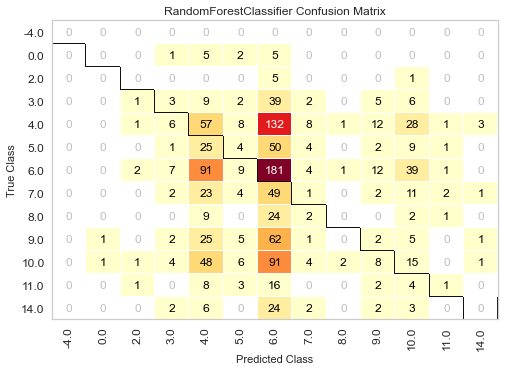

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [32]:
#ConfusionMatrix
model = RandomForestClassifier()
visualizer = ConfusionMatrix(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [33]:
# feature importances
clf_RFC.feature_importances_

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'